# PCA 主成份分析
## 目錄
--- 
1. Introduction
2. 資料前處理
3. 主成份分析
4. 選擇多少個組成份
    - 陡波圖(Scree plot)
5. 線性組合的係數
6. 主成分負荷圖
7. 參考資源
--- 

## 1. Introduction
PCA 是一種用來有效地降低數據的維度，簡單來說是一種降維的方式，意思是將原本高維的數據（N 個特徵），重新轉換成低維的形式（變成 K 個特徵），但在轉換的同時盡量保留原本數據的資訊量，我們就能在沒有損失什麼資訊的情況下，用更簡潔的方式呈現原本的數據。

PCA 具體而言，主成分可以看做一個線性方程式，其中包含一系列線性係數來只是投影方向。另一方面，這邊必須特別強調 PCA 對於雃使數據的正規化或預處理相當敏感（縮放）。

基本概念：
- 將座標軸中心一到數據的中心，然後旋轉座標軸，使得數據在 C1 軸（第一主成分）上的**變異數最大**，集全部 n 個數據個體在該方向上的投影最為分散，意味著保留著最多的訊息量
- C2 則是找到一個與 C1 共變異數為 0，使 C2 的訊息量不語 C1 重疊，並且使數據在這個方向的變異數盡量保持最大（也是為了保留最大的訊息量）
- 以此類推，用來找到第三個主成分、第四個主成分等等，若今天有 N 個隨機變數最多就能找到 N 個主成分。

----
今天我們所使用的資料集是 2020 MLB 各隊打擊數據資料集，檔案可以在 github 上找到，我們將利用這些資料來示範如何進行 PCA 特徵降維

In [1]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

## 載入資料集
資料集內有美國 MLB 31 隊的打擊數據，其中包含了一壘/二壘/三壘/全壘打的數量、得分、盜壘、三振、打擊率、長打率、上壘率等，但打擊率、長打率、上壘率等是由前項資料計算而成，因此我們先拿掉這三個欄位

In [2]:
data = pd.read_excel("2020_MLB.xls")
team = data['Tm']
data = data.loc[:, "R":"SO"]
columns = data.columns

In [3]:
data.head(5)

,R,H,2B,3B,HR,RBI,SB,CS,BB,SO
0,269,482,101,12,58,255,23,7,181,461
1,348,556,130,3,103,338,23,4,239,573
2,274,523,102,7,77,264,19,14,164,514
3,292,552,118,7,81,278,31,9,187,545
4,265,422,82,8,74,248,24,10,229,568


In [4]:
data.describe()

,R,H,2B,3B,HR,RBI,SB,CS,BB,SO
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,278.129032,481.290323,94.096774,8.032258,76.806452,265.935484,29.451613,9.741935,203.064516,519.548387
std,32.045532,46.136171,13.372496,3.439805,15.546531,31.167222,12.123912,3.492542,28.693711,41.016126
min,219.000000,390.000000,73.000000,3.000000,51.000000,204.000000,14.000000,3.000000,147.000000,440.000000
25%,251.500000,440.500000,82.500000,5.500000,62.500000,243.000000,20.000000,8.000000,183.500000,485.000000
50%,275.000000,481.000000,94.000000,7.000000,77.000000,264.000000,26.000000,9.000000,203.000000,521.000000
75%,296.500000,521.000000,103.000000,11.500000,87.000000,286.500000,34.000000,11.000000,229.000000,545.000000
max,349.000000,556.000000,130.000000,16.000000,118.000000,338.000000,55.000000,20.000000,251.000000,608.000000


## 2. 資料前處理
進行 PCA 之前，非常重要且必須注意的是 PCA 很容易受到資料的尺度所影響，因此進行 PCA 之前，需對資料進行標準化！

In [5]:
std = StandardScaler()
data_std = std.fit_transform(data)

In [6]:
data_std_pd = pd.DataFrame(data_std, columns = columns)
data_std_pd.head(5)

,R,H,2B,3B,HR,RBI,SB,CS,BB,SO
0,-0.289586,0.015637,0.524759,1.172546,-1.229684,-0.356665,-0.540936,-0.798061,-0.781678,-1.451044
1,2.216407,1.646097,2.729237,-1.487131,1.712699,2.350410,-0.540936,-1.671233,1.273084,1.324727
2,-0.130979,0.919000,0.600775,-0.305053,0.012655,-0.063126,-0.876316,1.239341,-1.383936,-0.137509
3,0.440007,1.557964,1.817039,-0.305053,0.274201,0.393488,0.129825,-0.215946,-0.569116,0.630784
4,-0.416472,-1.306359,-0.919554,-0.009533,-0.183503,-0.584972,-0.457091,0.075112,0.918815,1.200809


## 3. 主成分分析
接下來我們利用 sklearn 套件中的 PCA 來進行示範

In [7]:
from sklearn.decomposition import PCA

首先，我們先給定要生成的主成分數量有 5 個

In [8]:
pca = PCA(n_components=5).fit(data_std)

先觀察各個欄位間的共變異數

In [9]:
pd.DataFrame(pca.get_covariance())

,0,1,2,3,4,5,6,7,8,9
0,1.138712,0.742303,0.733890,0.067142,0.770283,0.954745,0.014766,-0.416913,0.402179,-0.222631
1,0.742303,1.095116,0.769297,0.195885,0.510259,0.750920,0.002105,-0.171241,-0.144396,-0.178765
2,0.733890,0.769297,0.876875,0.131368,0.536248,0.735212,0.091556,-0.160824,0.038740,-0.155492
3,0.067142,0.195885,0.131368,1.024369,-0.313027,0.061098,0.207253,-0.068618,-0.270299,-0.246425
4,0.770283,0.510259,0.536248,-0.313027,0.982813,0.775756,-0.121827,-0.403479,0.493398,-0.008798
5,0.954745,0.750920,0.735212,0.061098,0.775756,1.141738,-0.023586,-0.442671,0.392326,-0.219871
6,0.014766,0.002105,0.091556,0.207253,-0.121827,-0.023586,1.020186,0.552401,0.001272,0.119190
7,-0.416913,-0.171241,-0.160824,-0.068618,-0.403479,-0.442671,0.552401,1.023835,-0.378936,-0.023592
8,0.402179,-0.144396,0.038740,-0.270299,0.493398,0.392326,0.001272,-0.378936,0.996500,-0.019726
9,-0.222631,-0.178765,-0.155492,-0.246425,-0.008798,-0.219871,0.119190,-0.023592,-0.019726,1.033190


先來看一下結果，可以發現我們將原本 10 個維度縮減成 5 個維度

In [10]:
pca_df = pd.DataFrame(pca.transform(data_std), columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
pca_df.head(5)

,PCA1,PCA2,PCA3,PCA4,PCA5
0,-0.357234,-1.109842,-2.144395,-0.472886,0.003270
1,4.997595,1.409617,1.021363,1.482114,0.382651
2,-0.018809,-1.074148,-0.260848,1.435029,-1.359041
3,1.638203,-0.878157,0.382823,1.550297,-0.003640
4,-1.338834,1.488218,0.352001,-0.211454,0.857527


此外，我們有許多關於 PCA 的參數可以進行使用，稍後我們也會經常使用到：
- n_components_
- explained_variance_
- explained_variance_ratio_

## 4. 選擇多少個主成分？
當我們會使用 PCA 來降維後，隨即而來我們必須了解的是，我們究竟該取多少個主成分，才能有效的降低維度卻又不失去資料的原有的資訊量呢？我們可以利用 scree plot 來選擇

### 陡坡圖 Scree plot
透過該圖我們可以發現在 PCA 低於 3 之後的變異量已經相當小了，因此可以只取到 3 個主成份

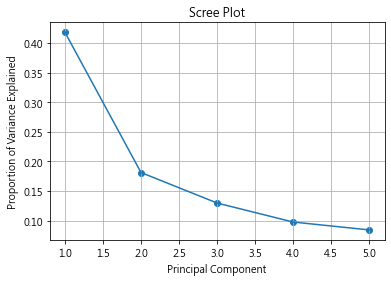

In [11]:
importance = pca.explained_variance_ratio_
plt.scatter(range(1,6),importance)
plt.plot(range(1,6),importance)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

另一種更直覺的圖則是累積解釋比例圖，我們可以看隨著取的主成份越多，累積解釋原本資料的能力的變化情形

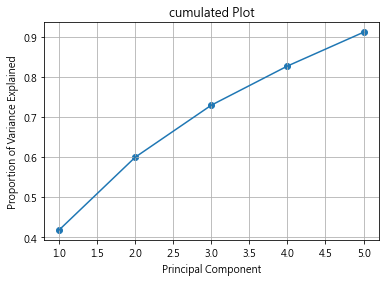

In [12]:
cumulated = []
total = 0
for i in importance:
    total+= i
    cumulated.append(total)

plt.scatter(range(1,6),cumulated)
plt.plot(range(1,6),cumulated)
plt.title('cumulated Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.grid()
plt.show()

很直覺的是當我們取了 3 個主成份時，可以解釋原資料中0.74左右的變異量

## 5. 線性組合的係數
每一個主成份，都是原特徵值經過線性組合後所產生的值，若原本有 n 個原變數（columns），則可以投影出 n 個主成份。

比如說：

$PC_1 = ∅_{11}X_1+∅_{12}X_2+...+∅_{1n}X_n$<br>
$PC_2 = ∅_{21}X_1+∅_{22}X_2+...+∅_{2n}X_n$<br>
$PC_3 = ∅_{31}X_1+∅_{32}X_2+...+∅_{3n}X_n$<br>
$PC_n = ∅_{n1}X_1+∅_{n2}X_2+...+∅_{nn}X_n$<br>

我們在得到 PCA 之後，為了解釋我們的結果，我們可以試著觀察一下每個主成份的係數組成來說明，其中，觀察原變數在線性組合中的係數(Φ；特徵向量)，可以知道主成份和原變數之間的關係(例如：正影響/負影響；影響程度多大)。

In [13]:
factor_loading = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=columns)
factor_loading

,PC1,PC2,PC3,PC4,PC5
R,0.475781,-0.044226,0.069525,-0.096002,0.040107
H,0.382074,-0.336341,-0.048442,0.359231,-0.099545
2B,0.367737,-0.246214,0.074066,0.166034,-0.047144
3B,0.012794,-0.477724,-0.377059,-0.259478,0.584897
HR,0.395928,0.230965,0.202343,0.063922,-0.114766
RBI,0.478974,-0.031354,0.040635,-0.065816,0.035189
SB,-0.048505,-0.389910,0.623154,-0.305757,0.253347
CS,-0.239767,-0.377695,0.446794,-0.037768,-0.433861
BB,0.187352,0.445764,0.230602,-0.555810,0.151980
SO,-0.105551,0.219909,0.401800,0.595470,0.595170


- 從以上表格我們可以發現在第一主成份中，得分、安打（一二三全壘打）、得分、四壞球都是正相關，可以推論與**成功的打擊**有關
- 第二主成份正相關的有全壘打、四壞球、三振，與**投手對決**有關

## 6. 主成份負荷圖
我們可以藉有繪出主成份負荷圖來觀察每支球隊的特性是什麼：

In [14]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = np.arange(31))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

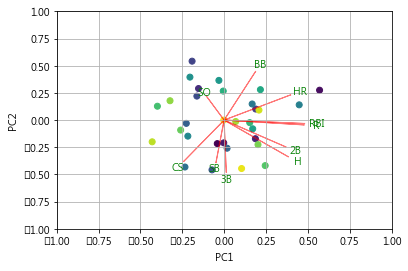

In [15]:
myplot(pca.transform(data_std),np.transpose(pca.components_[0:2, :]), labels=columns)
plt.show()

這張圖可以發現一個有趣的結果，如果有看棒球的球迷會發現一些事
- 靠近右上的球隊，通常都是出現四壞球、全壘打、打點等，這類型的球隊通常在現代棒球會被稱為“飛球革命”後的球隊，又稱 TTO 類型球隊
- 而靠近右下角的球隊的表現比較偏向傳統攻擊型球隊，透過不斷安打來取得分數
- 左下角的球隊就比較有類似小球、戰術風格的球隊，會不斷執行盜壘來作為攻擊手段

## 7. 總結
本篇以 2020 年美國職棒資料進行主成份分析作為示範，練習如何挑選幾個主成份，並且對於背後所代表的意義進行衍伸探討。

主成份分析是一種非監督式學習的方法，在進行的時候要先做正規化避免受到誤差產生影響。此外，因為該方法是對原始的資料進行投影、旋轉等，因此有時候在解釋上會較難以解釋，然而，只要能從主成份中找到有趣的故事，可能就能從中發現一些有價值的策略或者理解。

## 8. 參考資源
- R筆記–(7)主成份分析(2012美國職棒MLB)
https://rpubs.com/skydome20/R-Note7-PCA
- sklearn PCA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Principal component analysis (PCA) and visualization using Python
https://www.reneshbedre.com/blog/principal-component-analysis.html